# 9.3 Naive Bayes classifiers

## 9.3.1 Example models

> We show how to implement Naive Bayes classifiers from scratch.  
> We use binary features, and 2 classes.  
> Based on sec 18.9 of http://d2l.ai/chapter_appendix-mathematics-for-deep-learning/naive-bayes.html.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# helper function to show images
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    p = int(np.sqrt(imgs.shape[1]))
    assert p * p == imgs.shape[1]
    # modified from https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs.reshape(-1, p, p))):
        img = np.asarray(img)
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    fig.tight_layout()
    return axes

### Get MNIST data from www.openml.org

We use a binarized version of MNIST (`mnist_784`).

https://www.openml.org/search?type=data&status=active&id=554

In [4]:
%%time
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
X /= 255
y = y.astype('int64') # str -> int
X.shape, X.dtype, y.shape, y.dtype

CPU times: total: 13.7 s
Wall time: 14 s


((70000, 784), dtype('float64'), (70000,), dtype('int64'))

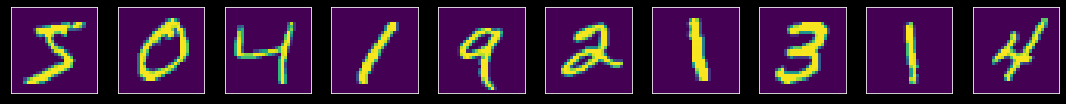

In [5]:
# original images
show_images(X[:10], 1, 10);

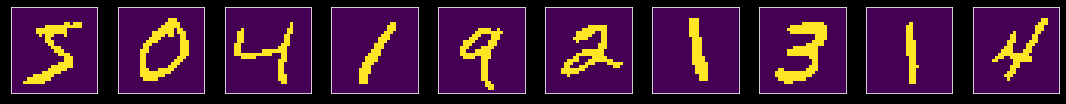

In [6]:
# binarized images
show_images(X[:10] > 0.5, 1, 10);

### Figure 9.6: Visualization of the Bernoulli class conditional densities for a naive Bayes classifier fit to a binarized version of MNIST dataset.

In [7]:
# Use binarized MNIST (X > 0.5)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X > 0.5, y, test_size=10000, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [8]:
# Training set is not equally balanced across classes...
N_c = np.array([(y_train == c).sum() for c in range(10)])
pi_c = N_c / N_c.sum()
N_c, pi_c

(array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]),
 array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
        0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ]))

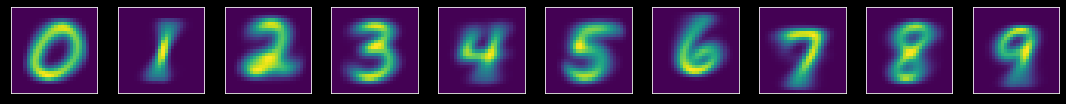

In [9]:
N_dc = np.array([X_train[y_train == c].sum(axis=0) for c in range(10)])
# Equation 9.58 using pseudo counts of 1 (add-one smoothing)
theta_dc = (1 + N_dc) / (2 + N_c).reshape(-1, 1)
show_images(theta_dc, 1, 10);

### Figure 9.7: Visualization of the predictions made by the model in Figure 9.6 when applied to some binarized MNIST test images. The title shows the most probable predicted class.

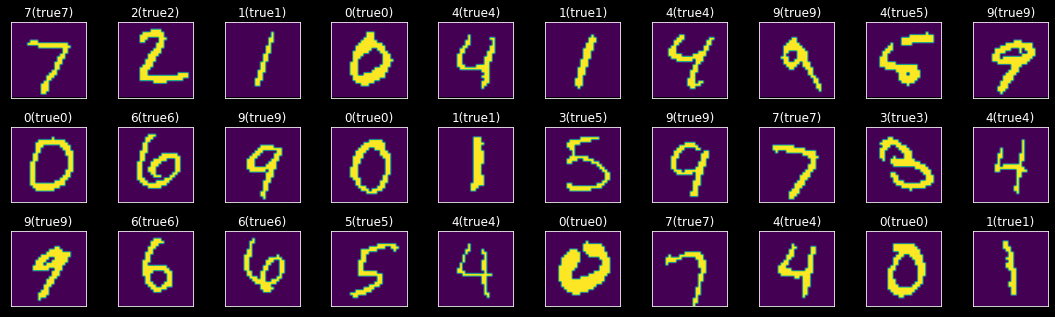

In [10]:
def predict(X, pi_c, theta_dc):
    log_pi_c = np.log(pi_c)
    log_theta_dc = np.log(theta_dc)
    log_theta_dc_neg = np.log(1 - theta_dc)

    def bayes_pred_stable(x):
        # x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
        x = np.expand_dims(x, 0)  # (28, 28) -> (1, 28, 28)
        log_p_x = log_theta_dc * x + log_theta_dc_neg * (1 - x)  # select the 0 and 1 pixels
        log_p_x = log_p_x.reshape(10, -1).sum(axis=1)  # log p(x|theta_dc)
        return log_pi_c + log_p_x

    return np.array([np.argmax(bayes_pred_stable(x)) for x in X])

X1, y1 = X_test[:30], y_test[:30]
preds = predict(X1, pi_c, theta_dc)
show_images(X1, 3, 10, titles=[f"{d}(true{y})" for d, y in zip(preds, y1)]);

In [11]:
# Mean accuracy of the test set
preds = predict(X_test, pi_c, theta_dc)
np.count_nonzero(preds == y_test) / len(y_test)

0.8427

### A. Multivariate Bernoulli naive Bayes with scikit-learn

In [12]:
# Use original MNIST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [13]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(alpha=1.0, binarize=0.5)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8427

In [14]:
# class_count_: Number of samples encountered for each class during fitting.
# class_log_prior_: Log probability of each class
# feature_count_: Number of samples encountered for each (class, feature) during fitting.
# feature_log_prior_: Empirical log probability of features given a class (smoothed)
np.allclose(clf.class_count_, N_c), \
np.allclose(clf.class_log_prior_, np.log(pi_c)), \
np.allclose(clf.feature_count_, N_dc), \
np.allclose(clf.feature_log_prob_, np.log(theta_dc))

(True, True, True, True)

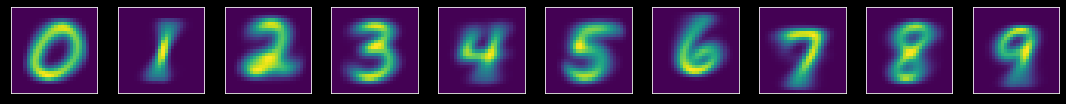

In [15]:
# Figure 9.6:
show_images(np.exp(clf.feature_log_prob_), 1, 10);

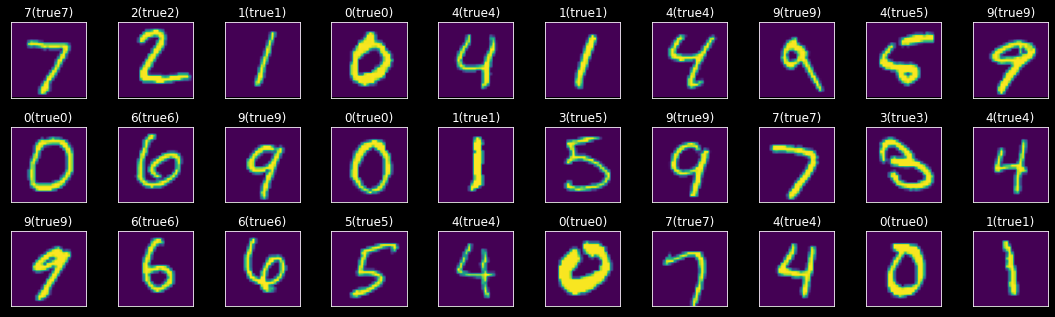

In [16]:
# Figure 9.7:
preds = clf.predict(X_test[:30])
show_images(X_test[:30], 3, 10, titles=[f"{d}(true{y})" for d, y in zip(preds, y_test[:30])]);

### B. Multivariate Gaussian naive Bayes with scikit-learn

In [24]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5558

In [25]:
# theta_: Mean of each feature per class, of shape (n_classes, n_features)
# var_: Variance of each feature per class, of shape (n_classes, n_features)
clf.theta_.shape, clf.var_.shape

((10, 784), (10, 784))

### C. Multinomial naive Bayes with scikit-learn

In [44]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8357

In [45]:
clf.class_count_, clf.feature_count_

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

### D. Complement naive Bayes with scikit-learn

In [46]:
from sklearn.naive_bayes import ComplementNB
c_clf = ComplementNB()
c_clf.fit(X_train, y_train)
c_clf.score(X_test, y_test)

0.7286

In [63]:
# class_count_ and feature_count_ are the same as MNB
np.all(clf.class_count_ == c_clf.class_count_), \
np.all(clf.feature_count_ == c_clf.feature_count_), \
np.all(c_clf.feature_all_ == c_clf.feature_count_.sum(axis=0))

(True, True, True)

### E. LDA classification of MNIST data

In [30]:
%%time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(solver='svd', n_components=2)
X_trans = clf.fit_transform(X_train, y_train)
clf.score(X_test, y_test)

CPU times: total: 14.8 s
Wall time: 7.53 s


0.873

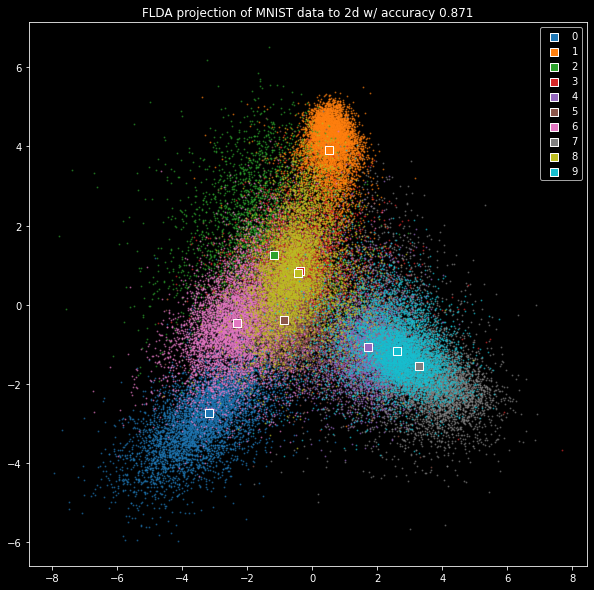

In [31]:
classes = np.unique(y_train)
muC = np.stack([X_train[y_train == c].mean(axis=0) for c in classes], axis=0) # shape (10, 784)
muC_trans = clf.transform(muC)

from matplotlib.colors import TABLEAU_COLORS
_, ax = plt.subplots(figsize=(10,10))
for label, c in zip(classes, TABLEAU_COLORS.values()):
    ndx = np.where(y_train == label)
    ax.scatter(X_trans[ndx, 0], X_trans[ndx, 1], s=1, c=c, alpha=0.5)
for label, c in zip(classes, TABLEAU_COLORS.values()):    
    ax.scatter(muC_trans[label, 0], muC_trans[label, 1], s=50, c=c, marker='s', edgecolors='white', label=label)
ax.set_title(f"FLDA projection of MNIST data to 2d w/ accuracy {clf.score(X_train, y_train):.3f}")
ax.legend();

In [32]:
%%time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(solver='lsqr', n_components=2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

CPU times: total: 5.5 s
Wall time: 3.58 s


0.873

In [33]:
# Generate `LinAlgError`: The leading minor of order 1 of B is not positive definite.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(solver='eigen', n_components=2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

LinAlgError: The leading minor of order 1 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

### F. QDA classification of MNIST data

In [34]:
%%time
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

c:\Users\chof\mambaforge\envs\probml\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


CPU times: total: 19.7 s
Wall time: 5.23 s


0.9361